In [9]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Sensing/'
num_cores = 12 #number of cores for parallelization

# System parameters for periodic boundary condition spin chain
J = 1.0  # +ve is Ferromagnet [Hamiltonian as defined Mishra, Bayat, PRL 127, 080504 (2021)]
gamma = 1.0
sites = 10
h1_amp = 1.5 #amplitude of the drive
h1_period = 2*3.14/1.0 #period of the drive

# Initial state
initial_state = 'ground_state' 
# 'ground_state': starts in the system ground-state. 
# 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
# 'momentum': a k = 0 momentum state. Even parity = PBC.
# 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Boundary conditions
boundary_conditions = 'ABC' 
# 'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions
# The boundary conditions must reflect the fermion parity in the initial conditions (see above).
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

# Time parameters
dt = 0.001 # time step
oneperiod_steps = int(h1_period/dt) # number of steps in one period
final_time = 500 # time in stroboscopic units
method = 'RK4' # integration method 'heun' or 'RK4'

# Sensing parameters
phasepoints = 1 # number of points for calculating h0
h0mat = np.linspace(1.0, 1.0, phasepoints)  # range of h0 points to sample
sub_system = 4 # range of subsystem sizes for evaluating Fisher information

# Computational for Fisher information (with 2nd order derivate approximation)
tol = 10**(-12) # when evaluating the Fisher information we don't consider singular terms for which |w[rr] + w[ss]| < tol 
shift = 10**(-6) # finite division size for calculating derivative of reduced density matrix, i.e. drho/dh0 ~ (rho(h0) - rho(h0 + shift))/shift for the order2 version
#save_results = 'save' # 'save' or 'bin' (don't save)

# Initialize the periodic field
h1 = h1_amp*np.sin(2*np.pi/(h1_period)*dt*np.arange(0,oneperiod_steps)) # initialize periodic field
h1_midpoint = h1_amp*np.sin(2*np.pi/(h1_period)*dt*(0.5 + np.arange(0,oneperiod_steps))) # vector at the mid-point between time-steps, required for RK4 due to explicit time-dependance



Calculate the eigenvalues and state of the Floquet unitary

In [10]:
#def Fisher_floquet(J, gamma, h0, h1, h1_midpoint, time, oneperiod_steps, dt, sites, boundary_conditions, method):
    
# Calculate state after 1 period starting from a basis state. This is used to build Floquet unitary.

h0 = h0mat[0]

Fisher_mat = []
particle_number = []
quasi_energy = []

basis_state = []

for kk in range(0,sites):

    basis_state = basis_state + [np.asarray([1,0])] #basis state is up (occupied state), initial down-state used in method

state = methods.integrator_BdG(J, gamma, h0, h1, h1_midpoint, oneperiod_steps, dt, sites, boundary_conditions, basis_state, method)
#state = methods.integrate_bdg_eff(basis_state, h1, J, gamma, h0, dt, oneperiod_steps, sites, boundary_conditions)

# Initial state is a list of vectors (u_k,v_k) 
# Build the Floquet unitary and calculate eigenvalues, eigenvectors in this basis
eval, evec = methods.floquet_eigsystem(state)

print('Eigensystem evaluated')

########## Now again for the perturbed system
basis_state = []

for kk in range(0,sites):

    basis_state = basis_state + [np.asarray([1,0])] #basis state is up (occupied state), initial down-state used in method

state = methods.integrator_BdG(J, gamma, h0 + shift, h1, h1_midpoint, oneperiod_steps, dt, sites, boundary_conditions, basis_state, method)
#state = methods.integrate_bdg_eff(basis_state, h1, J, gamma, h0 + shift, dt, oneperiod_steps, sites, boundary_conditions)

# Initial state is a list of vectors (u_k,v_k) 
# Build the Floquet unitary and calculate eigenvalues, eigenvectors in this basis
eval_pert, evec_pert = methods.floquet_eigsystem(state)

print('Perturbed eigensystem evaluated')

# Calculate the initial ground-state

initial_state = methods.initial_BdG(J, gamma, h0, h1, sites, boundary_conditions)

initial_state_pert = methods.initial_BdG(J, gamma, h0 + shift, h1, sites, boundary_conditions)

for time in range(0,final_time,1):

    print(time)

    #Unperturbed result
    obs, Dag_obs, quasienergy = methods.floquet_evolution(J, gamma, h0, h1, h1_midpoint, time, oneperiod_steps, dt, sites, boundary_conditions, method, eval, evec, initial_state)

    #Convert to the Majorana correlation matrix and calculate the Fisher information.
    Gamma_mat = methods.fermion_to_Majorana(obs, Dag_obs, sub_system)

    #Perturbed result
    obs_pert, Dag_obs_pert, eigval_pert = methods.floquet_evolution(J, gamma, h0 + shift, h1, h1_midpoint, time, oneperiod_steps, dt, sites, boundary_conditions, method, eval_pert, evec_pert, initial_state_pert)

    #Convert to the Majorana correlation matrix and calculate the Fisher information.
    Gamma_pert = methods.fermion_to_Majorana(obs_pert, Dag_obs_pert, sub_system)
    
    #Fisher information from Gamma (majorana) correlation matrix for sub-system
    Fisher = methods.Fisher_from_Gamma_2ndOrder(Gamma_mat, Gamma_pert, shift, tol, sub_system)

    Fisher_mat = Fisher_mat + [Fisher]

    particle_number = particle_number + [obs[0,0]]


#print(time)
#output = Parallel(n_jobs=num_cores)(delayed(Fisher_floquet)(J, gamma, h0mat[phase], h1, h1_midpoint, time, oneperiod_steps, dt, sites, boundary_conditions, method) for phase in range(0,phasepoints))
#collect output of parallel computation
#for kk in range(0,phasepoints):
#data = output[kk]
#quasi_energy = quasi_energy + [data[2]]




Eigensystem evaluated
Perturbed eigensystem evaluated
0
avoid singularity index 0
1
avoid singularity index 0
2
avoid singularity index 0
3
avoid singularity index 0
4
avoid singularity index 0
5
avoid singularity index 0
6
avoid singularity index 0
7
avoid singularity index 0
8
avoid singularity index 0
9
avoid singularity index 0
10
avoid singularity index 0
11
avoid singularity index 0
12
avoid singularity index 0
13
avoid singularity index 0
14
avoid singularity index 0
15
avoid singularity index 0
16
avoid singularity index 0
17
avoid singularity index 0
18
avoid singularity index 0
19
avoid singularity index 0
20
avoid singularity index 0
21
avoid singularity index 0
22
avoid singularity index 0
23
avoid singularity index 0
24
avoid singularity index 0
25
avoid singularity index 0
26
avoid singularity index 0
27
avoid singularity index 0
28
avoid singularity index 0
29
avoid singularity index 0
30
avoid singularity index 0
31
avoid singularity index 0
32
avoid singularity index 0

In [ ]:
np.save('Results_Floquet/Fisher_mat.npy',Fisher_mat)
np.save('Results_Floquet/h0mat.npy',h0mat)
np.save('Results_Floquet/particle_number.npy',particle_number)
np.save('Results_Floquet/final_time.npy',final_time)

np.save('Results_Floquet/Fisher_mat_t1.npy',Fisher_mat)
np.save('Results_Floquet/h0mat_t1.npy',h0mat)
np.save('Results_Floquet/particle_number_t1.npy',particle_number)
np.save('Results_Floquet/final_time_t1.npy',final_time)

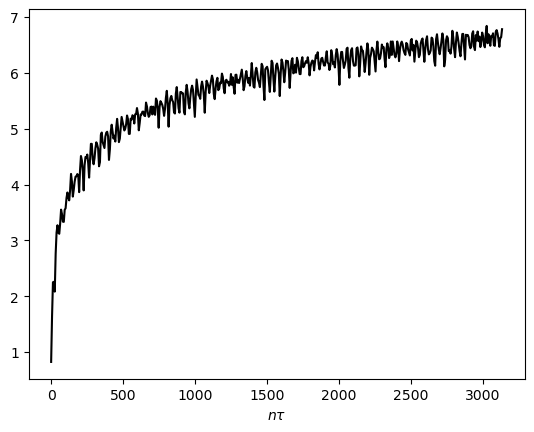

In [12]:
plt.plot(h1_period*np.arange(0,final_time),np.log10(Fisher_mat),'k')
plt.xlabel(r"$n\tau$")
plt.show()